In [250]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
import gensim
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel

import matplotlib.pyplot as plt
%matplotlib inline

# In this notebook, we wrap up our analysis of Box Office Performance + Text

We do the following:
* Build a dataset without outliers (bottom 20%, top 20%)
* Split analysis by genre
* Define buckets for low, medium and high grossing movies (balanced vs imbalanced)
* Compare model with concrete words (week 1) vs. dimensions/word ranks (week 2)
* Build a model that uses concrete words, dimensions and word ranks for classification

# A. Load NF dimensions and embedding model

In [2]:
# assume that we have a dimensions csv file in data
dimensions = pd.read_csv('data/dimensions.csv', usecols = ['en_label', 'en'])

In [3]:
# remove brand-specific labels
dimensions = dimensions.iloc[:200]

In [4]:
# remove rows with no words
dimensions = dimensions[~dimensions['en'].isnull()]

In [5]:
# turn to lowercase
dimensions['en_label'] = dimensions['en_label'].str.lower()
dimensions['en'] = dimensions['en'].str.lower()

In [15]:
# tokenize words
dimensions['tokenized'] = dimensions['en'].str.replace('-', '_').str.replace(',', ' ').map(word_tokenize)

In [16]:
# load embedding model
emb = gensim.models.KeyedVectors.load_word2vec_format('data/en_en_numberbatch_v1706.bin', binary=True)

In [17]:
def get_average_vector(words):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys()]
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [18]:
dimensions['dimension'] = dimensions['tokenized'].map(get_average_vector)
dimensions = dimensions.drop(columns=['en'])

In [19]:
dimensions = dimensions.reset_index().drop(columns='index')

In [20]:
# get word ranks from embedding model
word_rank = pd.Series(list(emb.vocab.keys())).reset_index()

In [21]:
# divide word ranks into deciles
word_rank['percentile'] = pd.qcut(word_rank['index'], 10, labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90+'])

In [22]:
rank_dict = dict(zip(word_rank[0].values, word_rank['percentile'].values))

In [23]:
rank_labels = word_rank['percentile'].unique()

# B. Create dataset w/o outliers

In this part, we load the dataset from the first week, filter out rows w/o filled up title and synopsis, and remove the bottom 20% and top 20% movies by average gross revenue per cinema.

In [24]:
# load data from the week 1 notebook
pc = pd.read_csv('data/wiki_matched.csv')

In [25]:
pc['tokenized_words'] = pc['movie_title'].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').str.replace(r'\'', '').map(word_tokenize)
pc['wiki_tokenized_words'] = pc['wiki_synopsis'].str.replace(r'[^a-zA-Z0-9 ]', '').str.replace(r'\'', '').map(word_tokenize)

In [26]:
# only retain genre, total gross per cinema, and text features
reduced = pc[['movie_title', 'genre1', 'genre2', 'adjusted_total_gross_per_cinema', 'wiki_synopsis', 'tokenized_words', 'wiki_tokenized_words']]

In [27]:
# get average word vectors assuming all words in the title/synopsis have equal weight
reduced['wv_title'] = reduced['tokenized_words'].map(get_average_vector)
reduced['wv_synopsis'] = reduced['wiki_tokenized_words'].map(get_average_vector)

C:\Users\pio_calderon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\pio_calderon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pio_calderon\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [29]:
def get_similarity_with_dimensions(row, inp, dimensions, tfidf = False):
    """
        Get similarity of row's word vector and every dimension.
        row : row of the movie dataframe
        inp : either 'title' or 'synopsis'
        dimensions : dataframe containing Neuroflash dimensions
        tfidf : true if we are using TFIDF-weighted sentence vectors
    """
    for k in range(dimensions['dimension'].shape[0]):
        if tfidf:
            wv = 'wv_' + inp + '_tfidf'
            name = 'cos_' + inp + '_dim_' + str(k) + '_tfidf'
        else: 
            wv = 'wv_' + inp
            name = 'cos_' + inp + '_dim_' + str(k)  
        # define a new column for the cosine similarity of dimension k and inp
        row[name] = cosine_similarity(row[wv], dimensions['dimension'].iloc[k])
    return row

In [30]:
def get_tfidf_wv(row, emb, d, col = 'wiki_tokenized_words'):
    """
        Get TFIDF-weighted vector for either title or synopsis.
        row : row of movie dataframe
        emb : embedding model used
        d : Gensim dictionary for the corpus
        col : either 'wiki_tokenized_words' (synopsis) or 'tokenized_words' (title)
    """
    if col == 'wiki_tokenized_words':
        tfidf_map = row['wiki_tfidf_map']
        name = 'wv_synopsis'
    else:
        tfidf_map = row['tfidf_map']
        name = 'wv_title'
    words = row[col]
    total = np.zeros(300)
    for word in words:
        if (word in d.token2id.keys() and d.token2id[word] in tfidf_map.keys() and word in emb.vocab.keys()):
            # use the TFIDF of word as the weight to the word vector of word
            total += np.array(tfidf_map[d.token2id[word]] * emb[word])
    count = len(total)
    if count == 0:
        row[name + '_tfidf'] = np.nan
    else:
        row[name + '_tfidf'] = total / count
    return row

In [31]:
def get_word_rank_count(row, inp, rank_dict, rank_labels):
    """
        Get the frequency of the word rank deciles <10 to 90+
        row : row of movie dataframe
        inp : either 'title' or 'synopsis'
        rank_dict : dictionary from words to ranks
        rank_labels : labels for the word rank deciles
    """
    if inp == 'title':
        val = 'tokenized_words'
    elif inp == 'synopsis':
        val = 'wiki_tokenized_words'
    else:
        return
    word_count = len(row[val])
    running = 0
    for k in range(10):
        # count the number of words belonging to decile k
        total = np.sum([1 for y in [rank_dict[x] for x in row[val] if x in rank_dict.keys()] if y == rank_labels[k]]) 
        # divide by the total number of words to get frequency
        freq = total / word_count
        row['freq_' + inp + '_'+ rank_labels[k]] = freq
        running += freq
    row['freq_' + inp + '_notinemb'] = 1 - running
    return row

In [32]:
# retain only rows with filled-up title and synopis
reduced = reduced[~reduced['wv_title'].isnull()]
reduced = reduced[~reduced['wv_synopsis'].isnull()]

In [33]:
reduced = reduced.apply(lambda x: get_word_rank_count(x, 'title', rank_dict, rank_labels), axis=1)
reduced = reduced.apply(lambda x: get_word_rank_count(x, 'synopsis', rank_dict, rank_labels), axis=1)

In [34]:
# divide the movies into 5-quantiles
reduced['gross_percentile'] = pd.qcut(reduced['adjusted_total_gross_per_cinema'], 5, labels = ['<20', '20-40', '40-60', '60-80', '>80'])

We remove movies that have gross in the top 20% and bottom 20%.

In [42]:
# remove bottom 20 and top 20 movies
no_blockbuster = reduced[~reduced['gross_percentile'].isin(['<20', '>80'])]

In [43]:
print("After removing outliers, we go from " + str(reduced.shape[0]) + " rows to " + str(no_blockbuster.shape[0]) + " rows.")

After removing outliers, we go from 3241 rows to 1953 rows.


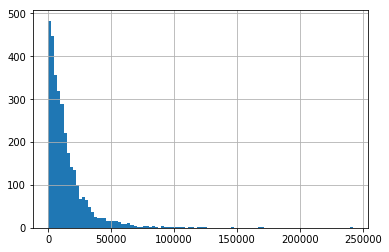

In [44]:
reduced['adjusted_total_gross_per_cinema'].hist(bins = 100);

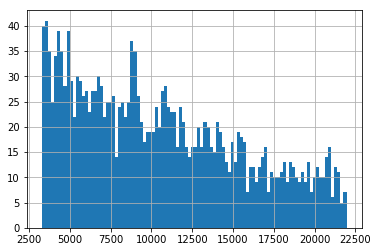

In [45]:
no_blockbuster['adjusted_total_gross_per_cinema'].hist(bins = 100)

Let us look at frequency counts per genre.

In [47]:
# considering only the first genre (some movies have an optional second genre)
no_blockbuster['genre1'].value_counts().sort_values(ascending=False).head()

Drama          450
Comedy         310
Foreign        289
Action         150
Documentary    149
Name: genre1, dtype: int64

In [48]:
# considering both first and second genre
no_blockbuster['genre1'].value_counts().add(no_blockbuster['genre2'].value_counts(), fill_value=0).sort_values(ascending=False).head()

Drama       662.0
Comedy      424.0
Foreign     289.0
Thriller    198.0
Action      195.0
dtype: float64

In our wrap-up, let us focus only on the top 3 genres: **Drama**, **Comedy** and **Foreign**.

# C. Class Definitions
We consider a 3-way multiclass problem for low, medium, high-grossing movies.

We will consider two types of binning: (1) binning with unequal binwidths based on 3-quantiles, which yields a balanced problem, and (2) equal binning with equal binwidths, which yields an imbalanced problem.

We will assess the performance of our models in the two problems defined above.

In [49]:
# divide movies into 3-quantiles, and assign movies belonging to the first, middle and last bin as low, medium and high-grossing movies
no_blockbuster['class_balanced'] = pd.qcut(no_blockbuster['adjusted_total_gross_per_cinema'],3, ['low', 'medium', 'high'])

C:\Users\pio_calderon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
# find out the min, max of the total gross, then divide the range by 3 to get the binwidth for the imbalanced problem
min_val = no_blockbuster['adjusted_total_gross_per_cinema'].min()
max_val = no_blockbuster['adjusted_total_gross_per_cinema'].max()
width = (max_val - min_val)/3

# this function maps each movie to its associated bin for the imbalanced problem
def map_class_imbalanced(x):
    if x < min_val + width:
        return 0
    elif x < min_val + 2* width:
        return 1
    else:
        return 2

In [51]:
no_blockbuster['class_imbalanced'] = no_blockbuster['adjusted_total_gross_per_cinema'].map(lambda x: map_class_imbalanced(x))

C:\Users\pio_calderon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [52]:
no_blockbuster['class_imbalanced'].value_counts() / no_blockbuster['class_balanced'].value_counts().sum()

0    0.489891
1    0.325557
2    0.196993
Name: class_imbalanced, dtype: float64

Almost a 3:2:1 imbalance ratio for equal binwidth

For the balanced problem, the bin edges are:

In [53]:
_, bins = pd.qcut(no_blockbuster['adjusted_total_gross_per_cinema'], 3, retbins=True)
bins

array([ 3302.35439901,  7284.96836185, 12569.40764852, 21960.        ])

In [54]:
no_blockbuster['class_balanced'] = pd.qcut(no_blockbuster['adjusted_total_gross_per_cinema'], 3, [0, 1, 2])

C:\Users\pio_calderon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [55]:
no_blockbuster['class_balanced'].value_counts()

2    643
1    643
0    643
Name: class_balanced, dtype: int64

For the balanced problem, we get balanced classes but unequal binwidth

# D. Generating Features and Datasets

In this part, we generate the features for the classification problem and split the dataset into train, validation and test.
* Let Model A refer to the model built on TFIDF weights of the concrete words in the title and synopsis
* Let Model B refer to the model built on dimension similarities and word ranks
* Let Model C refer to the model built on Model A and Model B's features

In [62]:
def generate_and_split_dataset_for_genre_classification(pc, emb, genre = '', var = 'class_balanced', concrete_words = True, similarity_rank = False, tfidf = False, whole = False):
    """
        Split train and tests sets for the specific genre
        
        Input:
            pc : dataframe of features
            emb : embedding model
            genre : genre to filter
            var : box office performance metric
            concrete_words : whether to use TFIDF of concrete words as features
            similarity_rank : whether to use dimension similarity and word rank as features
            tfidf : whether to use tfidf weighting to get embedding sentence vector
            whole: whether to train on whole dataset or not
        Output:
            X_train : input training set
            X_val : input validation set
            X_test : input test set
            y_train : output training set
            y_val : output validation set
            y_test : output test set
            column_names : list of feature names
    """
    
    # check whether genre is provided
    # if yes, filter pc by genre
    if genre == '':
        pc = pc
    else:
        pc = pc[(pc['genre1'] == genre) | (pc['genre2'] == genre)]
    
    # only retain rows with non-null performance metric
    pc = pc[~pc[var].isnull()]
    
    column_names = ['movie_title', 'wiki_synopsis', 'tokenized_words', 'wiki_tokenized_words', 'wv_title', 'wv_synopsis', var] + [x for x in pc.columns if 'freq' in x]
    X = pc[column_names]
    
    # whether to train on whole dataset or not
    if whole:
        X_train = X
        y_train = pc[var]
    
    else:
        # split 50-25-25 train-validation-test split
        X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                pc[var], test_size=0.25, stratify = pc[var], random_state=0)
        X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                y_trainval, test_size=1/3, stratify = y_trainval, random_state=0)
        X_train = pd.DataFrame(X_train, columns=column_names)
        X_val = pd.DataFrame(X_val, columns=column_names)
        X_test = pd.DataFrame(X_test, columns=column_names)

    if similarity_rank:
        # get maps of words to indices
        dict_synopsis = Dictionary(X_train['wiki_tokenized_words'].values)
        dict_title = Dictionary(X_train['tokenized_words'].values)

        # convert text to BOW representation
        corpus_synopsis_train = [dict_synopsis.doc2bow(line) for line in X_train['wiki_tokenized_words'].values]
        corpus_title_train = [dict_title.doc2bow(line) for line in X_train['tokenized_words'].values]

        # get TFIDF model from BOW repr.
        model_synopsis = TfidfModel(corpus_synopsis_train, id2word=dict_synopsis) 
        model_title = TfidfModel(corpus_title_train, id2word=dict_title) 

        if tfidf:
            # get TFIDF values for each word in each row
            X_train['wiki_tfidf_map'] = corpus_synopsis_train
            X_train['tfidf_map'] = corpus_title_train
            X_train['wiki_tfidf_map'] = X_train['wiki_tfidf_map'].map(lambda x: dict(model_synopsis[x]))
            X_train['tfidf_map'] = X_train['tfidf_map'].map(lambda x: dict(model_title[x]))
            # append columns to X_train that contains TFIDF-weighted sentence vectors
            X_train = X_train.apply(lambda x: get_tfidf_wv(x, emb, dict_synopsis, 'wiki_tokenized_words'), axis=1)
            X_train = X_train.apply(lambda x: get_tfidf_wv(x, emb, dict_title, 'tokenized_words'), axis=1)   

        # get similarity of sentence vectors with dimensions
        X_train = X_train.apply(lambda x: get_similarity_with_dimensions(x, 'title', dimensions, tfidf=tfidf), axis=1)
        X_train = X_train.apply(lambda x: get_similarity_with_dimensions(x, 'synopsis', dimensions, tfidf=tfidf), axis=1)    

        if tfidf:
            column_names = [x for x in X_train.columns if (((x.startswith('cos') and x.endswith('tfidf'))) or 'freq' in x)]
        else:
            column_names = [x for x in X_train.columns if ((x.startswith('cos')) or 'freq' in x)]

    if concrete_words:
        # obtain tfidf representation for words in the training set
        # only consider up to 2-grams, and filter out tokens appearing in < 4 titles
        tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 4)
        tfidf_features = tfidf.fit_transform(X_train['movie_title'].values)
        tfidf_df = pd.DataFrame(tfidf_features.toarray(), index = X_train.index,
                 columns=['title_' + x for x in tfidf.vocabulary_.keys()])

        # tfidf for the synopsis
        wiki_tfidf = TfidfVectorizer(stop_words='english', min_df = 20)
        wiki_tfidf_features = wiki_tfidf.fit_transform(X_train['wiki_synopsis'].values)
        wiki_tfidf_df = pd.DataFrame(wiki_tfidf_features.toarray(), index = X_train.index,
                 columns=['synopsis_' + x for x in wiki_tfidf.vocabulary_.keys()])
    
    to_concat = []
    if similarity_rank:
        to_concat.extend([X_train[column_names]])
    if concrete_words:
        to_concat.extend([tfidf_df, wiki_tfidf_df])
    X_train = pd.concat(to_concat, axis=1)
    
    pad = X_train.mean()
    X_train = X_train.fillna(pad)
    
    cols = X_train.columns
    
    # scale the dataset features
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)

    if whole:
        return X_train, None, None, y_train, None, None, cols

    else:
        # do the same procedure as done with the train set to the validation and test sets
        if similarity_rank:
            corpus_synopsis_val = [dict_synopsis.doc2bow(line) for line in X_val['wiki_tokenized_words'].values]
            corpus_title_val = [dict_title.doc2bow(line) for line in X_val['tokenized_words'].values]

            corpus_synopsis_test = [dict_synopsis.doc2bow(line) for line in X_test['wiki_tokenized_words'].values]
            corpus_title_test = [dict_title.doc2bow(line) for line in X_test['tokenized_words'].values]

            if tfidf:
                X_val['wiki_tfidf_map'] = corpus_synopsis_val
                X_val['tfidf_map'] = corpus_title_val
                X_val['wiki_tfidf_map'] = X_val['wiki_tfidf_map'].map(lambda x: dict(model_synopsis[x]))
                X_val['tfidf_map'] = X_val['tfidf_map'].map(lambda x: dict(model_title[x]))
                X_val = X_val.apply(lambda x: get_tfidf_wv(x, emb, dict_synopsis), axis=1)
                X_val = X_val.apply(lambda x: get_tfidf_wv(x, emb, dict_title, 'tokenized_words'), axis=1)

            X_val = X_val.apply(lambda x: get_similarity_with_dimensions(x, 'title', dimensions, tfidf=tfidf), axis=1)
            X_val = X_val.apply(lambda x: get_similarity_with_dimensions(x, 'synopsis', dimensions, tfidf=tfidf), axis=1)    

            if tfidf:
                X_test['wiki_tfidf_map'] = corpus_synopsis_test
                X_test['tfidf_map'] = corpus_title_test
                X_test['wiki_tfidf_map'] = X_test['wiki_tfidf_map'].map(lambda x: dict(model_synopsis[x]))
                X_test['tfidf_map'] = X_test['tfidf_map'].map(lambda x: dict(model_title[x]))
                X_test = X_test.apply(lambda x: get_tfidf_wv(x, emb, dict_synopsis), axis=1)
                X_test = X_test.apply(lambda x: get_tfidf_wv(x, emb, dict_title, 'tokenized_words'), axis=1)

            X_test = X_test.apply(lambda x: get_similarity_with_dimensions(x, 'title', dimensions, tfidf=tfidf), axis=1)
            X_test = X_test.apply(lambda x: get_similarity_with_dimensions(x, 'synopsis', dimensions, tfidf=tfidf), axis=1)    

        if concrete_words:
            # get tfidf representation of validation set
            tfidf_features_val = tfidf.transform(X_val['movie_title'].values)
            tfidf_df_val = pd.DataFrame(tfidf_features_val.toarray(), \
                    index = X_val.index, columns=tfidf_df.columns)
            wiki_tfidf_features_val = wiki_tfidf.transform(X_val['wiki_synopsis'].values)
            wiki_tfidf_df_val = pd.DataFrame(wiki_tfidf_features_val.toarray(), \
                    index = X_val.index, columns=wiki_tfidf_df.columns)
            
            # get tfidf representation of test set
            tfidf_features_test = tfidf.transform(X_test['movie_title'].values)
            tfidf_df_test = pd.DataFrame(tfidf_features_test.toarray(), \
                    index = X_test.index, columns=tfidf_df.columns)
            wiki_tfidf_features_test = wiki_tfidf.transform(X_test['wiki_synopsis'].values)
            wiki_tfidf_df_test = pd.DataFrame(wiki_tfidf_features_test.toarray(), \
                    index = X_test.index, columns=wiki_tfidf_df.columns)
            
        X_val = X_val.fillna(pad)
        X_test = X_test.fillna(pad)

        to_concat_val = []
        to_concat_test = []
        if similarity_rank:
            to_concat_val.extend([X_val[column_names]])
            to_concat_test.extend([X_test[column_names]])
        if concrete_words:
            to_concat_val.extend([tfidf_df_val, wiki_tfidf_df_val])
            to_concat_test.extend([tfidf_df_test, wiki_tfidf_df_test])

        X_val = pd.concat(to_concat_val, axis=1)
        X_test = pd.concat(to_concat_test, axis=1)
        
        X_val = ss.transform(X_val)
        X_test = ss.transform(X_test)

        return X_train, X_val, X_test, y_train, y_val, y_test, cols

In [71]:
def train_model(modeltype, X_train, y_train):
    """
        Train chosen model.
        
        Input:
            modeltype : 'lr'. I wrote this to be extendable easily.
            X_train : input training set
            y_train : output training set
        Output:
            model : trained logistic regression model
    """

    if modeltype == 'lr':
        model = LogisticRegression(class_weight='balanced', C=10)
    model.fit(X_train, y_train)
    return model

In [116]:
def evaluate_model(model, X, y, label):
    """
        Evaluate trained model.
        
        Input:
            model : classification model
            X : input to model
            y : output to predict
            label : model label, either A, B, C
        Output:
            dictionary containing the label, accuracy, recall, precision, f1 metrics
    """
    
    a = model.score(X, y)
    r = recall_score(y, model.predict(X), average='weighted')
    p = precision_score(y, model.predict(X), average='weighted')
    f = f1_score(y, model.predict(X), average='weighted')
    return {'label': label, 'accuracy': a, 'recall': r, 'precision': p, 'f1': f}

In [102]:
def evaluate_final_model(model, X, y):
    """
        Evaluate final model.
        
        Input:
            model : classification model
            X : input to model
            y : output to predict
    """
    
    print('accuracy : {}'.format(model.score(X, y)))
    print(classification_report(y, model.predict(X)))
    print(confusion_matrix(y, model.predict(X)))

In [244]:
def plot_most_relevant_features(model, column_names, n=5):
    """
        Plot the features which have the highest effect on
        box office performance based on the mode.
        
        Input:
            model : trained LR model
            column_names : list of features
            n : number of features to include (in one direction)
    """
    
    coef_low = model.coef_[0]
    coef_medium = model.coef_[1]
    coef_high = model.coef_[2]
    
    coef_low_sorted = list(coef_low[np.argsort(-coef_low)])
    columns_low_sorted = list(np.array(column_names)[np.argsort(-coef_low)])
    coef_medium_sorted = list(coef_medium[np.argsort(-coef_medium)])
    columns_medium_sorted = list(np.array(column_names)[np.argsort(-coef_medium)])
    coef_high_sorted = list(coef_high[np.argsort(-coef_high)])
    columns_high_sorted = list(np.array(column_names)[np.argsort(-coef_high)])    

    plt.figure(figsize=(15,6))
    
    plt.subplot(131)
    plt.bar(range(2*n), coef_low_sorted[:n] + coef_low_sorted[-n:])
    plt.xticks(range(2*n), columns_low_sorted[:n] + columns_low_sorted[-n:], rotation=270, size=15)
    plt.yticks(size=15)
    plt.ylabel('Coefficient', size=20)
    plt.title('Low gross', size=21);
    
    plt.subplot(132)
    plt.bar(range(2*n), coef_medium_sorted[:n] + coef_medium_sorted[-n:])
    plt.xticks(range(2*n), columns_medium_sorted[:n] + columns_medium_sorted[-n:], rotation=270, size=15)
    plt.yticks(size=15)
    plt.title('Medium gross', size=21);
    
    plt.subplot(133)
    plt.bar(range(2*n), coef_high_sorted[:n] + coef_high_sorted[-n:])
    plt.xticks(range(2*n), columns_high_sorted[:n] + columns_high_sorted[-n:], rotation=270, size=15)
    plt.yticks(size=15)
    plt.title('High gross', size=21);

### Generate features and dataset splits for Models A, B, C for Drama, Comedy and Foreign
Iterate over each combination of genre, model, and balanced/imbalanced problem to get train, validation and test data sets.

In [ ]:
for genre in ['Drama', 'Comedy', 'Foreign']:
    for similarity_rank in [False, True]:
        for concrete_word in [False, True]:
            for balanced in ['class_balanced', 'class_imbalanced']:                    
                print(genre, concrete_word, similarity_rank, balanced)
                if (not concrete_word and not similarity_rank):
                    continue
                X_train, X_val, X_test, y_train, y_val, y_test, column_names = \
                    generate_and_split_dataset_for_genre_classification(no_blockbuster, emb, genre = genre, var = balanced, \
                    concrete_words = concrete_word, similarity_rank = similarity_rank, tfidf = True, whole = False)
                if concrete_word:
                    if similarity_rank:
                        label = 'C'
                    else:
                        label = 'A'
                else:
                    label = 'B'
                pd.DataFrame(X_train, columns=column_names).to_csv('data/{}_model_{}_{}_X_train.csv'.format(genre, label, balanced), index=False)
                pd.DataFrame(X_val, columns=column_names).to_csv('data/{}_model_{}_{}_X_val.csv'.format(genre, label, balanced), index=False)
                pd.DataFrame(X_test, columns=column_names).to_csv('data/{}_model_{}_{}_X_test.csv'.format(genre, label, balanced), index=False)
                y_train.to_csv('data/{}_model_{}_{}_y_train.csv'.format(genre, label, balanced), index=False)
                y_val.to_csv('data/{}_model_{}_{}_y_val.csv'.format(genre, label, balanced), index=False)
                y_test.to_csv('data/{}_model_{}_{}_y_test.csv'.format(genre, label, balanced), index=False)

Get whole datasets for final models (see next section to see model evaluation)

In [255]:
balanced = 'class_imbalanced'
for genre in ['Drama', 'Comedy', 'Foreign']:
    X_train, _, _, y_train, _, _, column_names = \
        generate_and_split_dataset_for_genre_classification(no_blockbuster, emb, genre = genre, var = balanced, \
        concrete_words = True, similarity_rank = False, tfidf = True, whole = True)
    label = 'A'
    pd.DataFrame(X_train, columns=column_names).to_csv('data/{}_whole_model_{}_{}_X_whole.csv'.format(genre, label, balanced), index=False)
    y_train.to_csv('data/{}_model_{}_{}_y_whole.csv'.format(genre, label, balanced), index=False)
    
balanced = 'class_balanced'
for genre in ['Drama', 'Comedy', 'Foreign']:
    if genre == 'Drama':
        X_train, _, _, y_train, _, _, column_names = \
            generate_and_split_dataset_for_genre_classification(no_blockbuster, emb, genre = genre, var = 'class_balanced', \
            concrete_words = True, similarity_rank = True, tfidf = True, whole = True)
        label = 'C'
    else:
        X_train, _, _, y_train, _, _, column_names = \
            generate_and_split_dataset_for_genre_classification(no_blockbuster, emb, genre = genre, var = 'class_balanced', \
            concrete_words = False, similarity_rank = True, tfidf = True, whole = True)
        label = 'B'
    pd.DataFrame(X_train, columns=column_names).to_csv('data/{}_model_{}_{}_X_whole.csv'.format(genre, label, balanced), index=False)
    y_train.to_csv('data/{}_model_{}_{}_y_whole.csv'.format(genre, label, balanced), index=False)

C:\Users\pio_calderon\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\pio_calderon\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\pio_calderon\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

# E. Imbalanced Classification Problem
Here we focus on the imbalanced classification problem (binwidths are the same). We focus on drama, comedy and foreign films since they have the most data points.

In [124]:
def cross_validate_for_genre(genre, balance = 'class_imbalanced'):
    """
        Get evaluation metrics for models A, B, C for movies of the input genre and the specified type of
        binning (imbalanced or balanced)
        
        Input:
            genre : Drama, Comedy or Foreign
            balance : either class_imbalanced or class_balanced
        Output:
            df : dataframe containing evaluation metrics for models A, B, C
    """
    df = []
    for model_label in ['A', 'B', 'C']:        
        X_tr = pd.read_csv('data/{}_model_{}_{}_X_train.csv'.format(genre, model_label, balance))
        y_tr = pd.read_csv('data/{}_model_{}_{}_y_train.csv'.format(genre, model_label, balance), header = None).values.reshape(-1)
        model = train_model('lr', X_tr, y_tr)

        X_val = pd.read_csv('data/{}_model_{}_{}_X_val.csv'.format(genre, model_label, balance))
        y_val = pd.read_csv('data/{}_model_{}_{}_y_val.csv'.format(genre, model_label, balance), header = None).values.reshape(-1)
        df.append(evaluate_model(model, X_val, y_val, model_label))
    return pd.DataFrame(df)[['label', 'accuracy', 'precision', 'recall', 'f1']]

In [157]:
def evaluate_on_test_for_genre(genre, model_label, balance = 'class_imbalanced'):
    """
        Evaluate specified model (model_label) on the test set.
        
        Input:
            genre : Drama, Comedy or Foreign
            model_label : either 'A', 'B', 'C'
            balance : either class_imbalanced or class_balanced
        Output:
            series containing evaluation metrics
    """    
    X_tr = pd.read_csv('data/{}_model_{}_{}_X_train.csv'.format(genre, model_label, balance))
    y_tr = pd.read_csv('data/{}_model_{}_{}_y_train.csv'.format(genre, model_label, balance), header = None)
    X_val = pd.read_csv('data/{}_model_{}_{}_X_val.csv'.format(genre, model_label, balance))
    y_val = pd.read_csv('data/{}_model_{}_{}_y_val.csv'.format(genre, model_label, balance), header = None)

    X = pd.concat([X_tr, X_val], axis = 0, ignore_index = True)
    y = pd.concat([y_tr, y_val], axis = 0, ignore_index = True).values.reshape(-1)
    model = train_model('lr', X, y)
    
    X_te = pd.read_csv('data/{}_model_{}_{}_X_test.csv'.format(genre, model_label, balance))
    y_te = pd.read_csv('data/{}_model_{}_{}_y_test.csv'.format(genre, model_label, balance), header = None).values.reshape(-1)
    
    print(classification_report(y_te, model.predict(X_te)))
    print(confusion_matrix(y_te, model.predict(X_te)))
    return evaluate_model(model, X_te, y_te, model_label)

### Drama

In [125]:
cross_validate_for_genre('Drama')

,label,accuracy,precision,recall,f1
0,A,0.409639,0.403879,0.409639,0.406531
1,B,0.379518,0.370400,0.379518,0.374470
2,C,0.361446,0.361956,0.361446,0.360859


From the validation, **model A** (concrete words) performs best across all metrics. Let us see its performance on the test set:

In [158]:
evaluate_on_test_for_genre('Drama', 'A')

             precision    recall  f1-score   support

          0       0.59      0.52      0.55        85
          1       0.39      0.40      0.40        50
          2       0.15      0.19      0.17        31

avg / total       0.45      0.42      0.43       166

[[44 21 20]
 [15 20 15]
 [15 10  6]]


{'label': 'A',
 'accuracy': 0.42168674698795183,
 'recall': 0.42168674698795183,
 'precision': 0.44990945207017524,
 'f1': 0.433811277240477}

Now let's retrain the model on the whole dataset to see which features the model depends on.

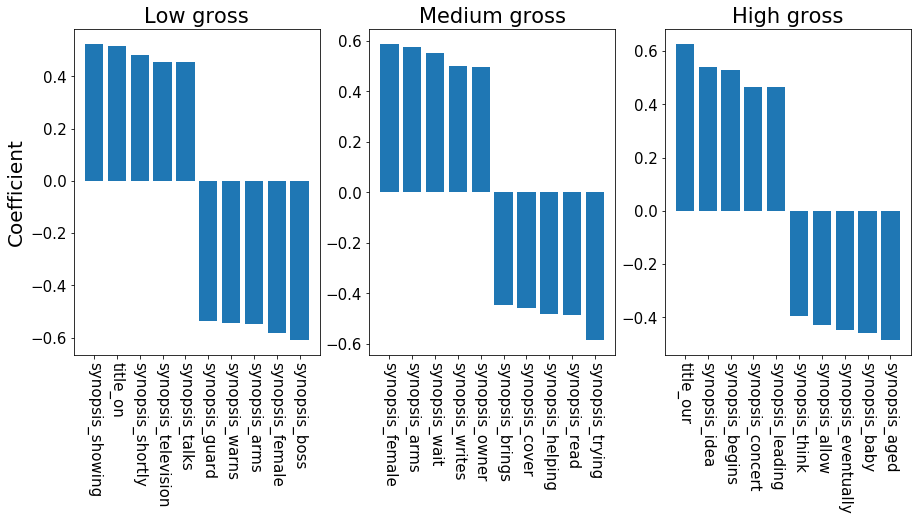

In [173]:
X = pd.read_csv('data/Drama_whole_model_A_class_imbalanced_X_whole.csv')
y = pd.read_csv('data/Drama_model_A_class_imbalanced_y_whole.csv', header = None).values.reshape(-1)
model = train_model('lr', X, y)
plot_most_relevant_features(model, X.columns, n=5)

### Comedy

In [126]:
cross_validate_for_genre('Comedy')

,label,accuracy,precision,recall,f1
0,A,0.405660,0.406182,0.405660,0.405722
1,B,0.349057,0.351876,0.349057,0.350334
2,C,0.339623,0.341517,0.339623,0.340528


From the validation, **model A** (concrete words) performs best across all metrics. Let us see its performance on the test set:

In [251]:
evaluate_on_test_for_genre('Comedy', 'A')

             precision    recall  f1-score   support

          0       0.42      0.40      0.41        48
          1       0.30      0.34      0.32        38
          2       0.17      0.15      0.16        20

avg / total       0.33      0.33      0.33       106

[[19 21  8]
 [18 13  7]
 [ 8  9  3]]


{'label': 'A',
 'accuracy': 0.330188679245283,
 'recall': 0.330188679245283,
 'precision': 0.33102237823606845,
 'f1': 0.3298898945928876}

Now let's retrain the model on the whole dataset to see which features the model depends on.

C:\Users\pio_calderon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


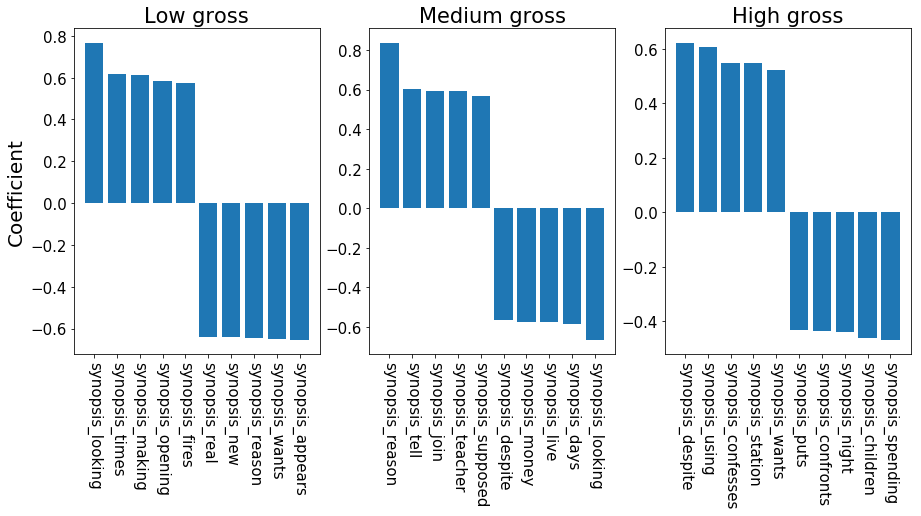

In [174]:
X = pd.read_csv('data/Comedy_whole_model_A_class_imbalanced_X_whole.csv')
y = pd.read_csv('data/Comedy_model_A_class_imbalanced_y_whole.csv', header = None)
model = train_model('lr', X, y)
plot_most_relevant_features(model, X.columns, n=5)

### Foreign

In [127]:
cross_validate_for_genre('Foreign')

,label,accuracy,precision,recall,f1
0,A,0.430556,0.440394,0.430556,0.430934
1,B,0.388889,0.437376,0.388889,0.379396
2,C,0.361111,0.378733,0.361111,0.367493


From the validation, **model A** (concrete words) performs best across all metrics. Let us see its performance on the test set:

In [160]:
evaluate_on_test_for_genre('Foreign', 'A')

             precision    recall  f1-score   support

          0       0.54      0.42      0.47        33
          1       0.37      0.42      0.39        26
          2       0.24      0.29      0.26        14

avg / total       0.42      0.40      0.40        73

[[14 12  7]
 [ 9 11  6]
 [ 3  7  4]]


{'label': 'A',
 'accuracy': 0.3972602739726027,
 'recall': 0.3972602739726027,
 'precision': 0.4191326267071634,
 'f1': 0.40394802588006445}

Now let's retrain the model on the whole dataset to see which features the model depends on.

C:\Users\pio_calderon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


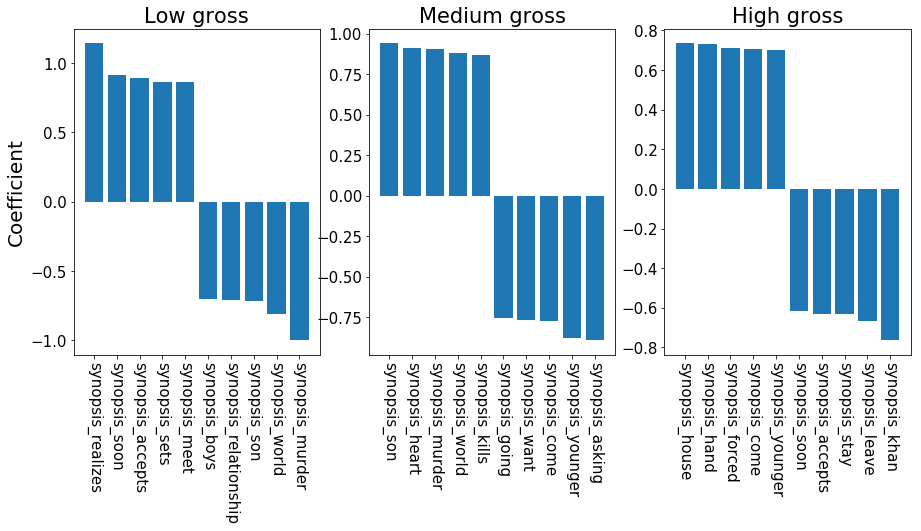

In [175]:
X = pd.read_csv('data/Foreign_whole_model_A_class_imbalanced_X_whole.csv')
y = pd.read_csv('data/Foreign_model_A_class_imbalanced_y_whole.csv', header = None)
model = train_model('lr', X, y)
plot_most_relevant_features(model, X.columns, n=5)

Observations:
* Quite difficult to assess performance since problem is imbalanced.
* However, performance isn't that great. Models are passable detecting low-grossing movies, but have difficult time distinguishing medium and high grossing movies.
* This could be a data issue since we are working with small sample sizes after the top-20-bottom-20 reduction.

# F. Balanced Classification Problem

### Drama

In [128]:
cross_validate_for_genre('Drama', 'class_balanced')

,label,accuracy,precision,recall,f1
0,A,0.353659,0.357148,0.353659,0.353621
1,B,0.341463,0.343373,0.341463,0.340817
2,C,0.353659,0.356076,0.353659,0.354599


From the validation, **model C** (mixed model) performs best accdg to F1. Let us see its performance on the test set:

In [257]:
evaluate_on_test_for_genre('Drama', 'C', 'class_balanced')

             precision    recall  f1-score   support

          0       0.34      0.38      0.36        56
          1       0.31      0.34      0.33        58
          2       0.23      0.18      0.20        51

avg / total       0.30      0.30      0.30       165

[[21 21 14]
 [22 20 16]
 [19 23  9]]


{'label': 'C',
 'accuracy': 0.30303030303030304,
 'recall': 0.30303030303030304,
 'precision': 0.2961331679073615,
 'f1': 0.2978702838330513}

Now let's retrain the model on the whole dataset to see which features the model depends on.

C:\Users\pio_calderon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


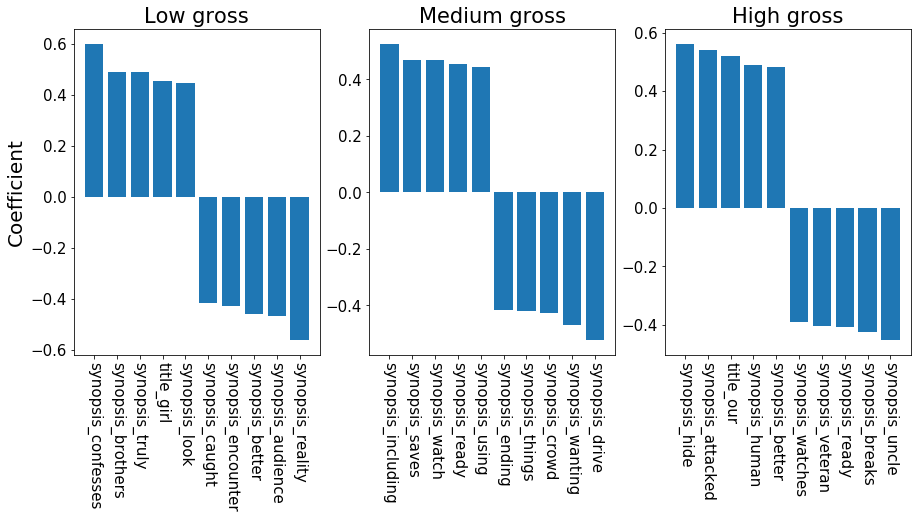

In [262]:
X = pd.read_csv('data/Drama_model_C_class_balanced_X_whole.csv')

y = pd.read_csv('data/Drama_model_C_class_balanced_y_whole.csv', header = None)
model = train_model('lr', X, y)

plot_most_relevant_features(model, X.columns, n=5)

### Comedy

In [129]:
cross_validate_for_genre('Comedy', 'class_balanced')

,label,accuracy,precision,recall,f1
0,A,0.330189,0.331033,0.330189,0.327853
1,B,0.367925,0.373705,0.367925,0.370114
2,C,0.330189,0.336453,0.330189,0.327114


From the validation, **model B** (dimensions and ranks) performs best across all metrics. Let us see its performance on the test set:

In [162]:
evaluate_on_test_for_genre('Comedy', 'B', 'class_balanced')

             precision    recall  f1-score   support

          0       0.21      0.19      0.20        31
          1       0.30      0.34      0.32        35
          2       0.32      0.30      0.31        40

avg / total       0.28      0.28      0.28       106

[[ 6 12 13]
 [10 12 13]
 [12 16 12]]


{'label': 'B',
 'accuracy': 0.2830188679245283,
 'recall': 0.2830188679245283,
 'precision': 0.2808909065115619,
 'f1': 0.28125261371183985}

Now let's retrain the model on the whole dataset to see which features the model depends on.

C:\Users\pio_calderon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


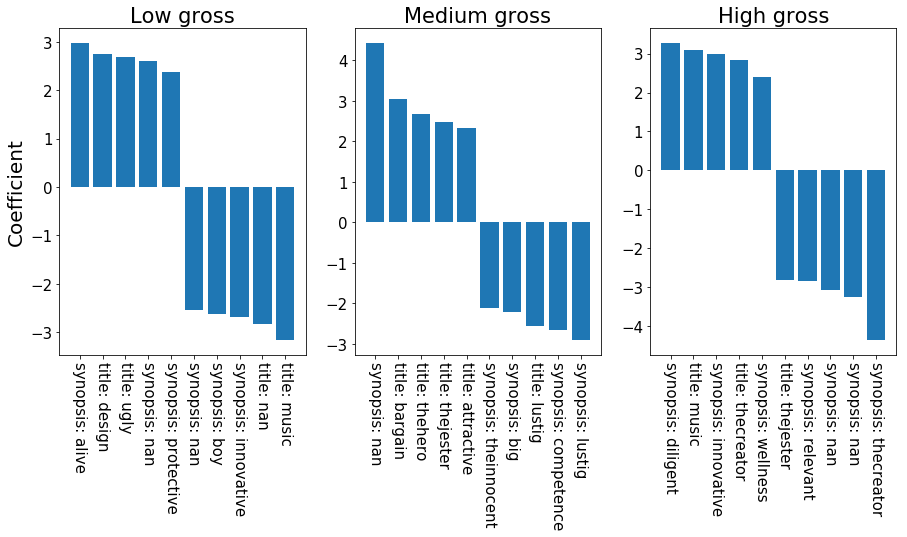

In [248]:
X = pd.read_csv('data/Comedy_model_B_class_balanced_X_whole.csv')
y = pd.read_csv('data/Comedy_model_B_class_balanced_y_whole.csv', header = None)
model = train_model('lr', X, y)

freq_label = pd.Series(X.columns[:22])
title_label = dimensions['en_label'].map(lambda x: 'title: ' + str(x))
synopsis_label = dimensions['en_label'].map(lambda x: 'synopsis: ' + str(x))
col_labels = pd.concat([freq_label, title_label, synopsis_label], ignore_index=True).values
X.columns = col_labels

plot_most_relevant_features(model, X.columns, n=5)

### Foreign

In [130]:
cross_validate_for_genre('Foreign', 'class_balanced')

,label,accuracy,precision,recall,f1
0,A,0.333333,0.328195,0.333333,0.328958
1,B,0.361111,0.382044,0.361111,0.350408
2,C,0.347222,0.355357,0.347222,0.341149


From the validation, **model B** (dimensions and ranks) performs best across all metrics. Let us see its performance on the test set:

In [164]:
evaluate_on_test_for_genre('Foreign', 'B', 'class_balanced')

             precision    recall  f1-score   support

          0       0.41      0.52      0.46        23
          1       0.27      0.17      0.21        24
          2       0.46      0.52      0.49        25

avg / total       0.38      0.40      0.39        72

[[12  5  6]
 [11  4  9]
 [ 6  6 13]]


{'label': 'B',
 'accuracy': 0.4027777777777778,
 'recall': 0.4027777777777778,
 'precision': 0.38228311439518337,
 'f1': 0.38614739558135786}

Now let's retrain the model on the whole dataset to see which features the model depends on.

C:\Users\pio_calderon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


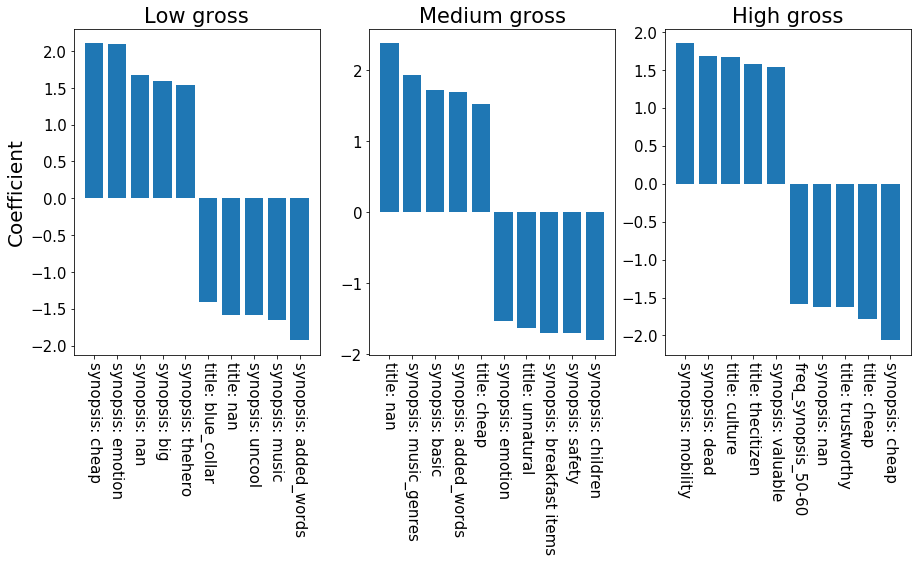

In [249]:
X = pd.read_csv('data/Foreign_model_B_class_balanced_X_whole.csv')
y = pd.read_csv('data/Foreign_model_B_class_balanced_y_whole.csv', header = None)
model = train_model('lr', X, y)

freq_label = pd.Series(X.columns[:22])
title_label = dimensions['en_label'].map(lambda x: 'title: ' + str(x))
synopsis_label = dimensions['en_label'].map(lambda x: 'synopsis: ' + str(x))
col_labels = pd.concat([freq_label, title_label, synopsis_label], ignore_index=True).values
X.columns = col_labels

plot_most_relevant_features(model, X.columns, n=5)

# Summary and Conclusion

* We compared logistic regression models built on the concrete words, similarity to Neuro Flash dimensions, and the combination of the two on two classification problems.
* For the imbalanced problem, model A (concrete words) performed best for Comedy, Drama, Foreign.
* For the balanced problem, it was a toss-up between models B (dimensions) and C (mixed).
* Overall, the predictive power of the models isn't that great, implying that there is a lot more to it than the wording of the text and synopsis to predict box office performance. 
* Coefficients of the logistic regression models can be used to see which factors (words or dimensions) the model picked up to correlate with high probability of being a low or a high grosser.
* A k-fold cross validation is recommended for future since low performance on test set might be due to unlucky splitting.